In [1]:
import pandas as pd

# Load the data
file_path = "data/Extended_Employee_Performance_and_Productivity_Data.csv"
dfOrig = pd.read_csv(file_path)

Based on https://www.kaggle.com/datasets/mexwell/employee-performance-and-productivity-data

In [2]:
dfOrig = dfOrig.sample(n=10000)
dfOrig.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 76776 to 77900
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Employee_ID                  10000 non-null  int64  
 1   Department                   10000 non-null  object 
 2   Gender                       10000 non-null  object 
 3   Age                          10000 non-null  int64  
 4   Job_Title                    10000 non-null  object 
 5   Hire_Date                    10000 non-null  object 
 6   Years_At_Company             10000 non-null  int64  
 7   Education_Level              10000 non-null  object 
 8   Performance_Score            10000 non-null  int64  
 9   Monthly_Salary               10000 non-null  float64
 10  Work_Hours_Per_Week          10000 non-null  int64  
 11  Projects_Handled             10000 non-null  int64  
 12  Overtime_Hours               10000 non-null  int64  
 13  Sick_Days        

In [3]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# Feature encoding for categorical variables
#from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
dfOrig['Department_enc'] = enc.fit_transform(dfOrig['Department'])
dfOrig['Gender_enc'] = enc.fit_transform(dfOrig['Gender'])
dfOrig['Job_Title_enc'] = enc.fit_transform(dfOrig['Job_Title'])
dfOrig['Hire_Date_enc'] = enc.fit_transform(dfOrig['Hire_Date'])
dfOrig['Education_Level_enc'] = enc.fit_transform(dfOrig['Education_Level'])
dfOrig['Risigned_enc'] = enc.fit_transform(dfOrig['Resigned'])


# Separate features and target
X = dfOrig[['Department_enc', 'Gender_enc', 'Age', 'Job_Title_enc', 'Hire_Date_enc', 'Years_At_Company', 'Education_Level_enc', 'Monthly_Salary', 'Work_Hours_Per_Week', 'Projects_Handled', 'Overtime_Hours', 'Sick_Days', 'Remote_Work_Frequency', 'Team_Size', 'Training_Hours', 'Promotions', 'Employee_Satisfaction_Score', 'Risigned_enc']]
y = dfOrig['Performance_Score']

# Using SelectKBest to select the top features based on mutual information
selector = SelectKBest(score_func=mutual_info_regression, k='all')
selector.fit(X, y)

# Get the scores and the p-values (if available, p-values might not be available for certain metrics like mutual_info_regression)
scores = selector.scores_

# Create a DataFrame to view the scores
feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': scores})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)

print(feature_scores)
relevant_scores = []
for item in feature_scores.iterrows():
    if (item[1]['Score'] > 0.0):
        relevant_scores.append(item[1]['Feature'])

print(relevant_scores)
relevant_scores

                        Feature     Score
7                Monthly_Salary  1.521009
17                 Risigned_enc  0.008198
4                 Hire_Date_enc  0.007216
12        Remote_Work_Frequency  0.006703
11                    Sick_Days  0.006660
10               Overtime_Hours  0.004890
1                    Gender_enc  0.002206
15                   Promotions  0.001700
13                    Team_Size  0.001110
8           Work_Hours_Per_Week  0.001107
2                           Age  0.000325
0                Department_enc  0.000065
6           Education_Level_enc  0.000000
5              Years_At_Company  0.000000
14               Training_Hours  0.000000
3                 Job_Title_enc  0.000000
16  Employee_Satisfaction_Score  0.000000
9              Projects_Handled  0.000000
['Monthly_Salary', 'Risigned_enc', 'Hire_Date_enc', 'Remote_Work_Frequency', 'Sick_Days', 'Overtime_Hours', 'Gender_enc', 'Promotions', 'Team_Size', 'Work_Hours_Per_Week', 'Age', 'Department_enc']


['Monthly_Salary',
 'Risigned_enc',
 'Hire_Date_enc',
 'Remote_Work_Frequency',
 'Sick_Days',
 'Overtime_Hours',
 'Gender_enc',
 'Promotions',
 'Team_Size',
 'Work_Hours_Per_Week',
 'Age',
 'Department_enc']

Min salery: 3850.0
Max salery: 9000.0
Median salery: 6500.0


<Axes: title={'center': 'Monthly salery'}, ylabel='Frequency'>

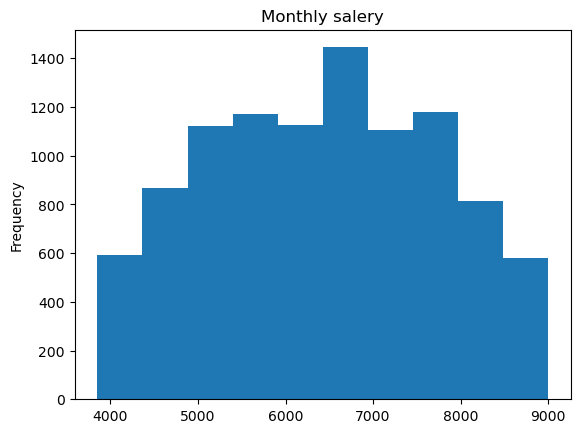

In [4]:
print('Min salery:', dfOrig['Monthly_Salary'].min())
print('Max salery:', dfOrig['Monthly_Salary'].max())
print('Median salery:', dfOrig['Monthly_Salary'].median())

dfOrig['Monthly_Salary'].plot(kind='hist', title='Monthly salery')
#dfOrig['Performance_Score'].plot(kind='hist', title='Performance_Score')

In [5]:
relevant_all = relevant_scores.copy()
relevant_all.append("Performance_Score")

df = dfOrig[relevant_all].copy() #dfOrig[['Performance_Score', 'Education_Level', 'Years_At_Company', 'Work_Hours_Per_Week', 'Age', 'Job_Title', 'Training_Hours']].copy()#[['Performance_Score', 'Education_Level']].copy()

# Define high performance
df['High_Performance'] = df['Performance_Score'].apply(lambda x: 1 if x >= 4 else 0)

# Define treatment higher salery
df['High_Salary'] = df['Monthly_Salary'].apply(lambda x: 1 if x >=  dfOrig['Monthly_Salary'].median() else 0)

print("Amount of samples in treatment group: ", df[df['High_Performance']==1].shape[0])
print("Amount of samples in control group: ", df[df['High_Performance']==0].shape[0])

Amount of samples in treatment group:  3887
Amount of samples in control group:  6113


In [6]:
df.columns
df.dtypes

Monthly_Salary           float64
Risigned_enc               int64
Hire_Date_enc              int32
Remote_Work_Frequency      int64
Sick_Days                  int64
Overtime_Hours             int64
Gender_enc                 int32
Promotions                 int64
Team_Size                  int64
Work_Hours_Per_Week        int64
Age                        int64
Department_enc             int32
Performance_Score          int64
High_Performance           int64
High_Salary                int64
dtype: object

In [7]:
relevant_scores
covariates = list(set(relevant_scores) - set(['Monthly_Salary'])) # the treatment variable should not be included in the covariates for the propensity score estimation!
print(covariates)

['Hire_Date_enc', 'Age', 'Work_Hours_Per_Week', 'Remote_Work_Frequency', 'Department_enc', 'Risigned_enc', 'Overtime_Hours', 'Gender_enc', 'Sick_Days', 'Team_Size', 'Promotions']


In [8]:
# Propensity score matching to obtain quasi-RCT
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

features = df[covariates] #df[['Job_Title_enc', 'Years_At_Company', 'Age', 'Department_enc']]
treatment = df['High_Salary']

# Use scaled features and logistic regression for propensity score prediction!
model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, solver='lbfgs'))

# Fit the model
model.fit(features, treatment)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [9]:
df['propensity_score'] = model.predict_proba(features)[:, 1]

control = df[df['High_Salary'] == 0].sort_values('propensity_score')
treated = df[df['High_Salary'] == 1].sort_values('propensity_score')

In [10]:
print(control['propensity_score'])
print(treated.shape)

3814     0.465927
15517    0.467137
99807    0.468397
7268     0.470005
80737    0.472250
           ...   
94928    0.549791
4368     0.550568
64523    0.550906
40166    0.553394
91402    0.555285
Name: propensity_score, Length: 4874, dtype: float64
(5126, 16)


In [11]:
import pandas as pd

# A small method to perform matching fast, i.e. in complexity O(N + M)
def perform_matching(treated_df, control_df, tolerance=0.01):
    # NOTE: Assumes treated_df and control_df to be sorted in ascending order with respect to the column "propensity_score"
    treated_matched_indices = []  # To store indices of matched treated samples
    control_matched_indices = []  # To store indices of matched control samples
    
    i, j = 0, 0  # Initialize pointers
    
    # Extract the propensity scores assuming they are in a column named 'propensity_score'
    treated_scores = treated_df['propensity_score'].values
    control_scores = control_df['propensity_score'].values
    
    while i < len(treated_scores) and j < len(control_scores):
        if abs(treated_scores[i] - control_scores[j]) <= tolerance:
            # If within tolerance, consider it a match
            treated_matched_indices.append(i)
            control_matched_indices.append(j)
            # Move both pointers to find next match
            i += 1
            j += 1
        elif treated_scores[i] < control_scores[j]:
            # Increment i to get closer to j
            i += 1
        else:
            # Increment j to get closer to i
            j += 1
    
    # Create new dataframes for matched samples
    treated_matched = treated_df.iloc[treated_matched_indices]
    control_matched = control_df.iloc[control_matched_indices]
    
    return treated_matched, control_matched

# Assume treated and control are your dataframes
treated_matched, control_matched = perform_matching(treated, control)

In [12]:
print("Amount of samples in treatment group: ", treated_matched.shape[0])
print("Amount of samples in control group: ", control_matched.shape[0])

# Save matched data to csv for quasi RCT study -> see RCT_study.ipynb
treated_matched.to_csv('treated_machted.csv', index=False)
control_matched.to_csv('control_matched.csv', index=False)

# Compute average treatment effect (ATE)
Y_1 = treated_matched['High_Performance'].apply(lambda x: 1 if x >= 1 else 0).mean()
print("The average of higher performance in the treatment group is: ", Y_1)
Y_0 = control_matched['High_Performance'].apply(lambda x: 1 if x >= 1 else 0).mean()
print("The average of higher performance in the control group is: ", Y_0)

print("The average treatment effect is: ", Y_1 - Y_0)

Amount of samples in treatment group:  4874
Amount of samples in control group:  4874
The average of higher performance in the treatment group is:  0.49035699630693474
The average of higher performance in the control group is:  0.28087812884694296
The average treatment effect is:  0.20947886745999178


<Axes: title={'center': 'Performance_Score - treated'}, ylabel='Frequency'>

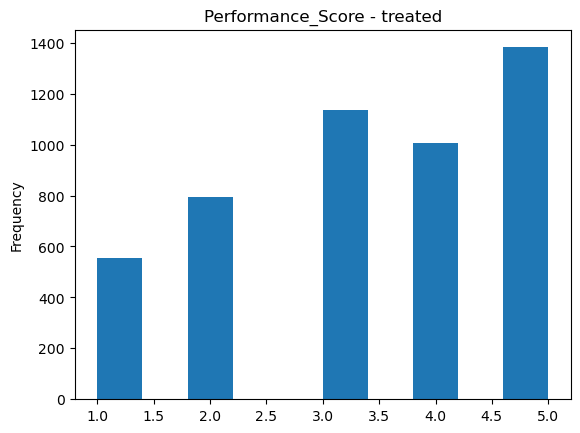

In [13]:
treated_matched['Performance_Score'].plot(kind='hist', title='Performance_Score - treated')

<Axes: title={'center': 'Performance_Score - control'}, ylabel='Frequency'>

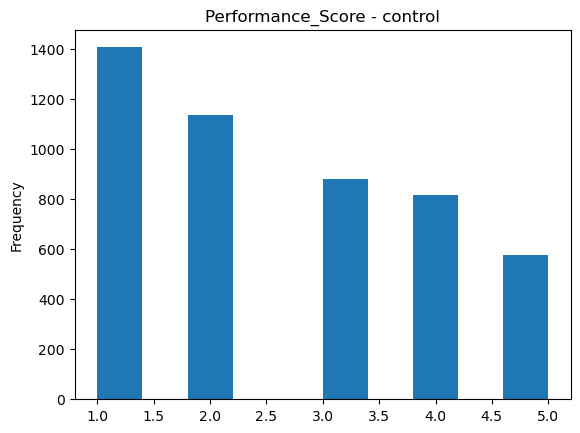

In [58]:
control_matched['Performance_Score'].plot(kind='hist', title='Performance_Score - control')